# Multivariate synthetic data

In [1]:
import sys
import os

SCRIPT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(SCRIPT_DIR)

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tueplots import bundles, figsizes

from bocpd import bocpd
from hazard import ConstantHazard
from models import DSMExponentialGaussian
from utils.find_cp import find_cp

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [2]:
DATA_PATH = os.path.join(SCRIPT_DIR,'data/synthetic')
RESULT_PATH = os.path.join(SCRIPT_DIR,'notebooks/results/synthetic')

## Generate data

In [3]:
np.random.seed(60)
T = 1000
data  = np.zeros((T, 2))
cps   = [250,750]
lambdas = [1/4, 1, 1/8]
mus = [0, 0, 8]
sigmas = [2, 1, 2]
scale = lambdas[0]
mu = mus[0]
var = sigmas[0]
for t in range(0, 1000):
    if t == cps[0]:
        scale = lambdas[1]
        mu = mus[1]
        var = sigmas[1]
    elif t == cps[1]:
        scale = lambdas[2]
        mu = mus[2]
        var = sigmas[2]
    data[t,0] = np.random.exponential(1/scale)
    data[t,1] = np.random.normal(mu, var)

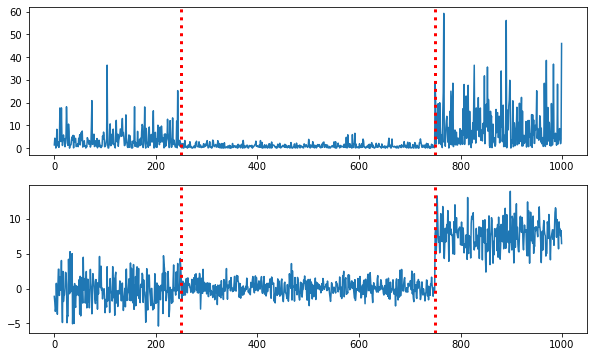

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(10,6))
ax[0].plot(range(0, 1000),data[:,0])
ax[1].plot(range(0, 1000),data[:,1])
for cp in cps:
    ax[0].axvline(cp, c='red', ls='dotted', lw=3)
    ax[1].axvline(cp, c='red', ls='dotted', lw=3)

## Define functions needed for the method: $m$, $\nabla m$ , $\nabla r$, $\nabla b$ , $\nabla^2 r$

In [5]:
def m(x):
    m = np.eye(2)
    m[0,0] = x[0]
    m[1,1] = (1+x[1]**2)**(-1/2)
    return m

def grad_m(x):
    m1 = np.zeros((2,2))
    m1[0,0] = 1
    m2 = np.zeros((2,2))
    m2[1,1] = -x[1]/((1+x[1]**2)**(3/2))
    return np.concatenate((np.asarray([m1]),np.asarray([m2])),axis=0)

def grad_r(x):
    grad_t1 = np.zeros((1,3))
    grad_t1[:,0] = -1
    grad_t2 = np.zeros((1,3))
    grad_t2[:,1] = 1
    grad_t2[:,2] = -x[1]
    return np.concatenate((grad_t1,grad_t2),axis=0)

def grad_b(x):
    return np.asarray([[0],[0]])

def hess_r(x):
    hess_t = np.zeros((2,2,3))
    hess_t[1,1,2]=-1
    return hess_t

## Prior parameters and $\omega$

In [6]:
omega = 0.1

lambda_mu0 = 1
mean_mu0 = 0
var_mu0 = 2

lambda_Sigma0 = 1
mean_Sigma0 = 4
var_Sigma0 = 10


mu0 = np.asarray([[lambda_mu0],[mean_mu0/var_mu0], [1/var_mu0]])

Sigma0 = np.eye(3)

Sigma0[0,0] = lambda_Sigma0
Sigma0[1,1] = mean_Sigma0/var_Sigma0
Sigma0[2,2] = 1/var_Sigma0

## Initialize model and CP prior

In [7]:
model = DSMExponentialGaussian(data, m ,grad_m, grad_r, hess_r, grad_b, omega, mu0, Sigma0, b = 40)

In [8]:
hazard = ConstantHazard(300)

## Run BOCD algorithm

In [9]:
%%time
R  = bocpd(data, hazard, model, verbose = True)

Processing observation #100
Processing observation #200
Processing observation #300
Processing observation #400
Processing observation #500
Processing observation #600
Processing observation #700
Processing observation #800
Processing observation #900
Processing observation #1000
CPU times: user 2min 20s, sys: 130 ms, total: 2min 20s
Wall time: 2min 20s


## Plot

/tmp/ipykernel_4778/2535842501.py:33: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace=0)


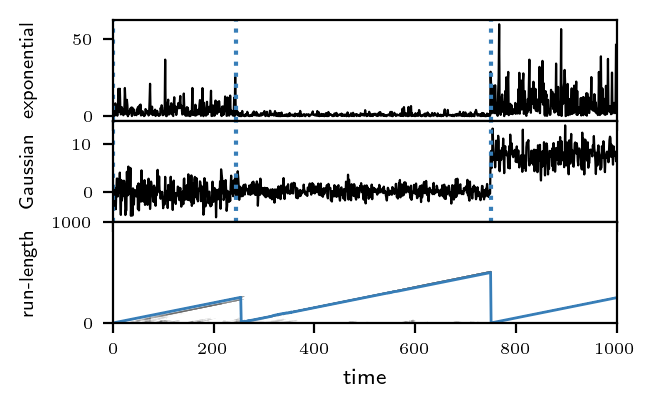

In [21]:
FILE_NAME = 'Synthetic.pdf'
cp_color = CB_color_cycle[0]
cps = find_cp(R)
with plt.rc_context(bundles.icml2022()):

    fig, ax = plt.subplots(3, 1, sharex = True, dpi = 200, gridspec_kw={'height_ratios': [1,1,1]})
    ax[0].set_xlim([0, T])
    ax[0].plot(range(0, 1000),data[:,0],color='black',lw=0.8)

    ax[1].set_xlim([0, T])
    ax[1].plot(range(0, 1000),data[:,1],color='black',lw=0.8)

    ax[2].set_xlim([0, T])
    ax[2].imshow(np.rot90(R), aspect='auto', cmap='gray_r', 
                   norm=LogNorm(vmin=0.0001, vmax=1), extent=[0,T,0,T])
    ax[2].plot(np.argmax(R,axis=1), c=cp_color,lw=1)

    for cp in cps:
        ax[0].axvline(cp, c=cp_color, ls='dotted', lw=1.5)
        ax[1].axvline(cp, c=cp_color, ls='dotted', lw=1.5)
        
        
    ax[2].set_xlabel('time')
    
    ax[0].set_ylabel('exponential' , size= 7)
    ax[1].set_ylabel('Gaussian', size= 7)
    ax[2].set_ylabel('run-length', size= 7)
    
    ax[0].yaxis.set_label_coords(-0.15,0.5)
    ax[1].yaxis.set_label_coords(-0.15,0.5)
    ax[2].yaxis.set_label_coords(-0.15,0.5)
    
    fig.subplots_adjust(hspace=0)
    fig.savefig(os.path.join(RESULT_PATH, FILE_NAME), format="png", bbox_inches= "tight")

/tmp/ipykernel_4778/1480106596.py:33: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace=0)


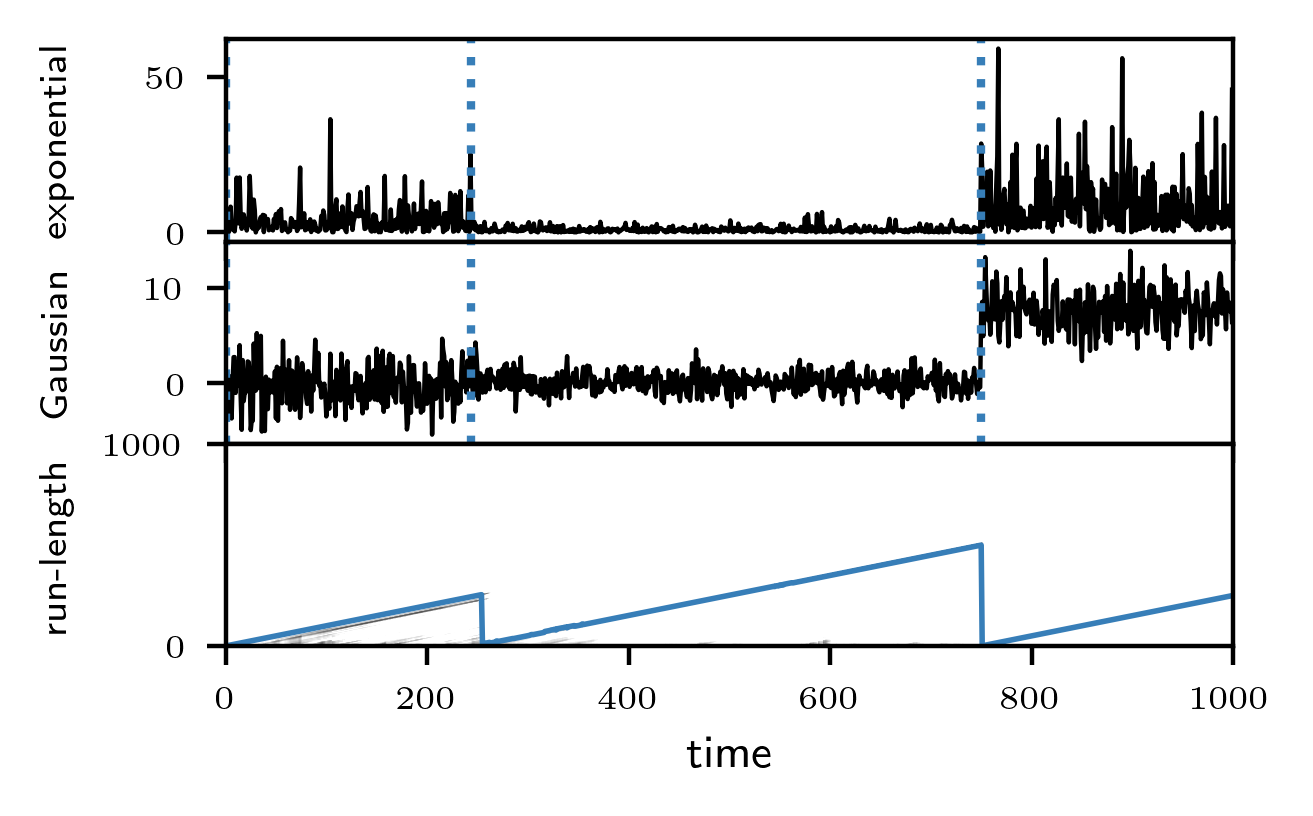

In [23]:
FILE_NAME = 'Synthetic.pdf'
cp_color = CB_color_cycle[0]
cps = find_cp(R)
with plt.rc_context(bundles.icml2022()):

    fig, ax = plt.subplots(3, 1, sharex = True, dpi = 400, gridspec_kw={'height_ratios': [1,1,1]})
    ax[0].set_xlim([0, T])
    ax[0].plot(range(0, 1000),data[:,0],color='black',lw=0.8)

    ax[1].set_xlim([0, T])
    ax[1].plot(range(0, 1000),data[:,1],color='black',lw=0.8)

    ax[2].set_xlim([0, T])
    ax[2].imshow(np.rot90(R), aspect='auto', cmap='gray_r', 
                   norm=LogNorm(vmin=0.0001, vmax=1), extent=[0,T,0,T])
    ax[2].plot(np.argmax(R,axis=1), c=cp_color,lw=1)

    for cp in cps:
        ax[0].axvline(cp, c=cp_color, ls='dotted', lw=1.5)
        ax[1].axvline(cp, c=cp_color, ls='dotted', lw=1.5)
        
        
    ax[2].set_xlabel('time')
    
    ax[0].set_ylabel('exponential' , size= 7)
    ax[1].set_ylabel('Gaussian', size= 7)
    ax[2].set_ylabel('run-length', size= 7)
    
    ax[0].yaxis.set_label_coords(-0.15,0.5)
    ax[1].yaxis.set_label_coords(-0.15,0.5)
    ax[2].yaxis.set_label_coords(-0.15,0.5)
    
    fig.subplots_adjust(hspace=0)
    fig.savefig(os.path.join(RESULT_PATH, FILE_NAME), format="pdf", bbox_inches= "tight")